# prepare np data(zarr, npy, lerobot) 

In [1]:
import zarr
import random
import os
import numpy as np
from diffusion_policy.codecs.imagecodecs_numcodecs import register_codecs
register_codecs()   # 由于添加了Jpeg压缩，读取时需要注册Jpeg2k


home_path = os.path.expanduser("~")
dataset_path = os.path.join(home_path, "hx/kuavo/Task16_nls/V_1/kuavo-zarr/Task16_nls.zarr.zip") # "用于训练的zarr数据集文件"
dataset_root = zarr.open(dataset_path, 'r')
print(dataset_root.tree())
episode_ends = dataset_root['meta']['episode_ends']
num_episodes = len(episode_ends)
select_num = 2
selected_episodes = random.sample(range(num_episodes), select_num) if num_episodes >= select_num else list(range(num_episodes))

train_data = {
    k: v for k, v in dataset_root['data'].items() if k.startswith('img')
}
train_data.update({
    'agent_pos': np.hstack((dataset_root['data']['state_joint_with_hand'][:,8:8],dataset_root['data']['state_joint_with_hand'][:,13:21])),   # 根据训练数据切片，只取前8个joint
    'action': np.hstack((dataset_root['data']['cmd_joint_with_hand'][:,8:8],dataset_root['data']['cmd_joint_with_hand'][:,13:21])),    # 根据训练数据切片，只取前8个joint
})


ModuleNotFoundError: No module named 'diffusion_policy'

In [ ]:
'''
# 512 1024 2048
/wks/dataset/dataset_wason_20250307/data/outputs/2025.03.09/23.31.47_train_diffusion_unet_image_Task11_Toy/checkpoints
5.0G    ./epoch=0060-train_loss=0.013.ckpt
5.0G    ./epoch=0080-train_loss=0.009.ckpt
5.0G    ./epoch=0100-train_loss=0.007.ckpt
5.0G    ./epoch=0120-train_loss=0.005.ckpt
5.0G    ./epoch=0140-train_loss=0.004.ckpt
5.0G    ./latest.ckpt

# 256 512 1024
/wks/dataset/dataset_wason_20250307/data/outputs/2025.03.07/21.26.03_train_diffusion_unet_image_Task11_Toy/checkpoints
1.8G    ./epoch=0060-train_loss=0.011.ckpt
1.8G    ./epoch=0080-train_loss=0.008.ckpt
1.8G    ./epoch=0100-train_loss=0.006.ckpt
1.8G    ./epoch=0120-train_loss=0.005.ckpt
1.8G    ./epoch=0140-train_loss=0.004.ckpt
1.8G    ./latest.ckpt
'''

import os
os.environ['HTTP_PROXY'] = 'http://192.168.10.18:7890'
os.environ['HTTPS_PROXY'] = 'http://192.168.10.18:7890'
os.environ['NO_PROXY'] = 'localhost,127.0.0.1'

print("HTTP_PROXY:", os.getenv('HTTP_PROXY'))
print("HTTPS_PROXY:", os.getenv('HTTPS_PROXY'))

# Task11_Toy
ckpt_path = "/wks/dataset/dataset_wason_20250307/data/outputs/2025.03.09/23.31.47_train_diffusion_unet_image_Task11_Toy/checkpoints/latest.ckpt"
ckpt_path = "/home/lejurobot/hx/kuavo_il/data/outputs/2025.03.16/23.29.31_train_diffusion_unet_image_Task11_Toy/checkpoints/epoch=0040-train_loss=0.016.ckpt"
ckpt_path = "/home/lejurobot/hx/kuavo_il/data/outputs/2025.03.16/23.29.31_train_diffusion_unet_image_Task11_Toy/checkpoints/latest.ckpt"

# Task12_zed_dualArm
ckpt_path = "/home/lejurobot/hx/kuavo_il/data/outputs/2025.03.20/17.08.24_train_diffusion_unet_image_Task12_zed_dualArm/checkpoints/latest.ckpt"
ckpt_path = "/home/lejurobot/hx/kuavo_il/data/outputs/2025.03.24/22.16.59_train_diffusion_unet_image_Task12_zed_dualArm/train_0/checkpoints/epoch=0040-train_loss=0.018.ckpt"

# Task14_cup
ckpt_path = "/home/lejurobot/hx/kuavo/Task14_cup/train_oridp/outputs/2025.03.28/19.36.40_train_diffusion_unet_image_Task14_cup/checkpoints/epoch=0090-train_loss=0.003.ckpt"
ckpt_path = "/home/lejurobot/hx/kuavo_il/data/outputs/2025.04.01/19.58.17_train_diffusion_unet_image_Task14_cup/checkpoints/epoch=0040-train_loss=0.010.ckpt"

# Task16_nls
ckpt_path = "/home/lejurobot/hx/kuavo/Task16_nls/V_1/train_oridp/data/outputs/2025.04.08/22.19.22_train_diffusion_unet_image_Task16_nls/checkpoints/epoch=0100-train_loss=0.005.ckpt"
ckpt_size = os.path.getsize(ckpt_path) / (1024 ** 3)
import time
import torch
import dill
import hydra
from diffusion_policy.real_world.real_inference_util import (
    get_real_obs_resolution, 
    get_real_obs_dict)
from diffusion_policy.common.pytorch_util import dict_apply
from diffusion_policy.workspace.base_workspace import BaseWorkspace
from diffusion_policy.policy.base_image_policy import BaseImagePolicy

# load checkpoint
payload = torch.load(open(ckpt_path, 'rb'), pickle_module=dill)
cfg = payload['cfg']
n_obs_steps = cfg.n_obs_steps
n_action_steps= cfg.n_action_steps
print(cfg.shape_meta.obs)
cls = hydra.utils.get_class(cfg._target_)
workspace = cls(cfg)
workspace: BaseWorkspace
workspace.load_payload(payload, exclude_keys=None, include_keys=None)

# hacks for method-specific setup.
delta_action = False
if 'diffusion' in cfg.name:
    # diffusion model
    policy: BaseImagePolicy
    policy = workspace.model
    if cfg.training.use_ema:
        policy = workspace.ema_model
    device = torch.device('cuda:3')
    policy.eval().to(device)
    # set inference params
    policy.num_inference_steps = 16 # DDIM inference iterations
    policy.n_action_steps = 15
else:
    raise RuntimeError("Unsupported policy type: ", cfg.name)

HTTP_PROXY: http://192.168.10.18:7890
HTTPS_PROXY: http://192.168.10.18:7890
{'img01': {'shape': [3, 224, 224], 'type': 'rgb'}, 'img02': {'shape': [3, 224, 224], 'type': 'rgb'}, 'agent_pos': {'shape': [8], 'type': 'low_dim'}}


/home/lejurobot/miniconda3/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lejurobot/miniconda3/envs/robodiff/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


### Kuavo

In [ ]:
import numpy as np
from collections import defaultdict
import tqdm
all_img: defaultdict[str, list] = defaultdict(list)
upBody_lowDim: defaultdict[str, list] = defaultdict(list)
def add_noise_to_images(images, noise_level=0.2):
    """ 给归一化图像添加噪声 """
    noise = (np.random.rand(*images.shape) * 2 - 1) * noise_level
    return np.clip(images + noise, 0, 1)

def add_noise_to_data(data, noise_scale=0.5):
    noise = np.random.uniform(-noise_scale, noise_scale, size=data.shape)
    return data + noise

def dp_predict(obs_seq, act_seq, policy, device):
    pred_actions, true_actions, true_states = [], [], []
    WINDOW_SIZE = 2
    for step in tqdm.trange(len(obs_seq['img01']) - (WINDOW_SIZE - 1) ):
        observation = {
            key: np.stack(values[step:step + WINDOW_SIZE])
            for key, values in obs_seq.items()
        }
        with torch.no_grad():
            obs_dict_np = get_real_obs_dict(
                env_obs=observation, shape_meta=cfg.task.shape_meta)
            obs_dict = dict_apply(obs_dict_np, 
                lambda x: torch.from_numpy(x).unsqueeze(0).to(device))
            result = policy.predict_action(obs_dict)
            action = result['action'][0].detach().to('cpu').numpy()
        pred_actions.append(action) 
        final_window_step = step + WINDOW_SIZE - 1
        true_actions.append(np.array(act_seq[final_window_step]))
        true_states.append(np.array(obs_seq['agent_pos'][final_window_step]))

    return pred_actions, true_actions, true_states

def prepare_dpdata_seq(dataset, eps_idx):
    start_idx = 0
    if eps_idx > 0:
        start_idx = episode_ends[eps_idx-1]
    end_idx = episode_ends[eps_idx]
    episode_length = end_idx - start_idx
    print(f"Episode {eps_idx} length: {episode_length}")
   
    obs_seq = {
        k: v[start_idx:end_idx] for k, v in dataset.items() if k.startswith('img')
    }
    obs_seq.update({
        'agent_pos': dataset['agent_pos'][start_idx:end_idx],
    })

    act_seq = dataset['action'][start_idx:end_idx]
    return obs_seq, act_seq

def main(selected_episodes, dataset, policy, device, code_from = 'diffusion_policy'):
    all_pred_actions, all_true_actions, all_true_states = [], [], []
    all_img = defaultdict(list)
    for eps_idx in selected_episodes:
        if code_from == 'lerobot':
            pass
        elif code_from == 'diffusion_policy':
            obs_seq, act_seq = prepare_dpdata_seq(dataset, eps_idx=eps_idx)
            pred_actions, true_actions, true_states = dp_predict(obs_seq, act_seq, policy, device)
            all_pred_actions.append(np.array(pred_actions))
            all_true_actions.append(np.array(true_actions))
            all_true_states.append(np.array(true_states))
            for key in [k for k in obs_seq.keys() if "img" in k]:
                all_img[key].append(obs_seq[key])
    upBody_lowDim = {
        "pred_actions": all_pred_actions,
        "true_actions": all_true_actions,
        "true_states": all_true_states,
    }
    return all_img, upBody_lowDim
all_img, upBody_lowDim = main(selected_episodes, train_data, policy, device, code_from='diffusion_policy')


Episode 23 length: 180


100%|██████████| 179/179 [00:57<00:00,  3.14it/s]


Episode 118 length: 181


100%|██████████| 180/180 [00:57<00:00,  3.14it/s]


In [ ]:
for k,v in upBody_lowDim.items():
    print(k, len(v), v[0].shape)

for k, v in all_img.items():
    print(k, len(v),v[0].shape)


pred_actions 2 (179, 15, 8)
true_actions 2 (179, 8)
true_states 2 (179, 8)
img01 2 (180, 224, 224, 3)
img02 2 (180, 224, 224, 3)


In [ ]:
def draw_predicted_result(task_name, all_img, upBody_lowDim, eps_idx, slice_idx = None):
    import numpy as np
    import matplotlib.pyplot as plt
    img_strips = []
    show_img_num = 18
    for img_name, img_eps in all_img.items():
        img_strip = np.concatenate(np.array(img_eps[eps_idx])[::len(img_eps[eps_idx])//show_img_num], axis=1)  # Row for images
        img_strips.append(img_strip)

    img_strip_combined = np.vstack(img_strips)
    
    JOINT_DIM_LABELS= ["zarm_l1_link", "zarm_l2_link", "zarm_l3_link", "zarm_l4_link", "zarm_l5_link", "zarm_l6_link", "zarm_l7_link", 
                  "dex_hand_l1_link", "dex_hand_l2_link", "dex_hand_l3_link", "dex_hand_l4_link", "dex_hand_l5_link", "dex_hand_l6_link", 
                  "zarm_r1_link", "zarm_r2_link", "zarm_r3_link", "zarm_r4_link", "zarm_r5_link", "zarm_r6_link", "zarm_r7_link", 
                  "dex_hand_r1_link", "dex_hand_r2_link", "dex_hand_r3_link", "dex_hand_r4_link", "dex_hand_r5_link", "dex_hand_r6_link", 
                  ] 
  
    figure_layout = [
            ['image'] * len(JOINT_DIM_LABELS[:7]),
            ['image'] * len(JOINT_DIM_LABELS[:7]),
            JOINT_DIM_LABELS[:7],
            JOINT_DIM_LABELS[7:13] + ['extra1'],
            JOINT_DIM_LABELS[13:-6] ,
            JOINT_DIM_LABELS[-6:]+ ['extra2'],
        ]

    plt.rcParams.update({'font.size': 7})
    fig, axs = plt.subplot_mosaic(figure_layout)
    fig.set_size_inches([30, 12]) 
    fig.suptitle(task_name, fontsize=15)
    if slice_idx is not None:
        SELECTED_JOINT = [x for slc in slice_idx for x in JOINT_DIM_LABELS[slc[0]:slc[1]]]
    else:
        SELECTED_JOINT = JOINT_DIM_LABELS[0:8] + JOINT_DIM_LABELS[13:21] 
    
    for action_dim, action_label in enumerate(SELECTED_JOINT):
        for low_dim_name, low_dim_values in upBody_lowDim.items():
            if 'pred' in low_dim_name:  
                selected_range = range(len(low_dim_values[eps_idx]) - 8)  # len(low_dim_values[eps_idx]) - 8
                draw_pred_num = 8
                for j in selected_range[::draw_pred_num]:  # select range
                    x_range = np.arange(j, j + min(draw_pred_num, 8))  
                    y_values = low_dim_values[eps_idx][j, :draw_pred_num, action_dim]  
                    axs[action_label].plot(x_range, y_values,  alpha=0.5, zorder=1)
                # axs[action_label].plot(low_dim_values[eps_idx][:, 0, action_dim], label=low_dim_name, alpha=1, zorder=0.5, linestyle='-')
    
            elif 'true_actions' in low_dim_name:    # (n, 26)
                axs[action_label].plot(low_dim_values[eps_idx][:, action_dim], label=low_dim_name, alpha=0.4, zorder=0.5, linestyle='-')
                
            # elif 'true_states' in low_dim_name:
            #     axs[action_label].plot(low_dim_values[eps_idx][:, action_dim], label=low_dim_name, alpha=0.7, zorder=0.5, linestyle='-', color='#2ecc71')
        axs[action_label].set_title(action_label)
        # axs[action_label].set_xlabel('Time in one episode')
        axs[action_label].legend()

    axs['image'].imshow(img_strip_combined)
    axs['image'].set_xlabel('Time in one episode (subsampled)')
    axs['image'].set_title('Image Comparison')

    plt.legend()
    plt.show()


/tmp/ipykernel_4087833/1554989918.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


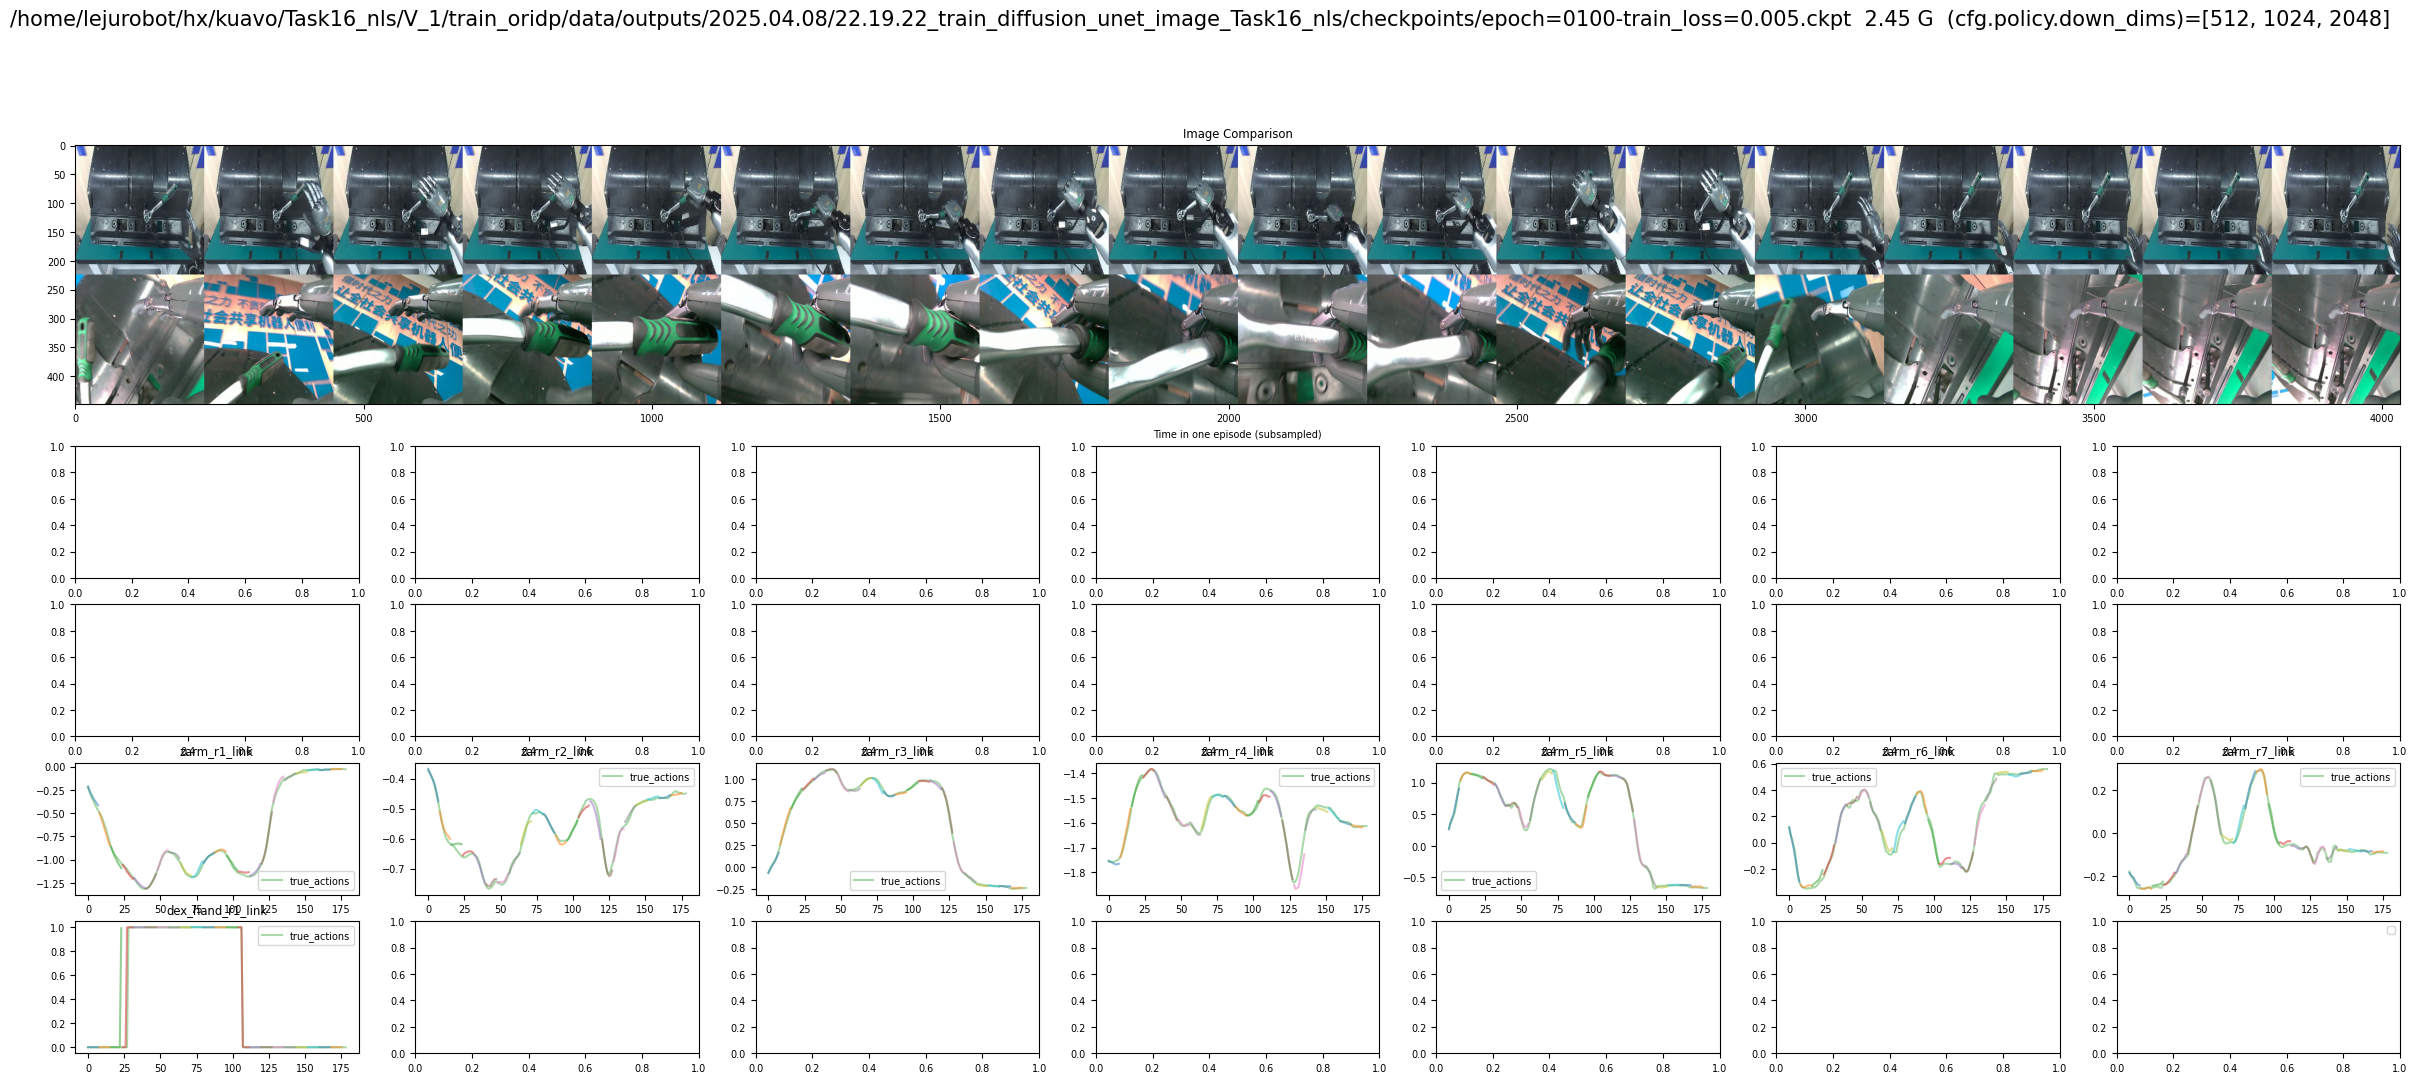

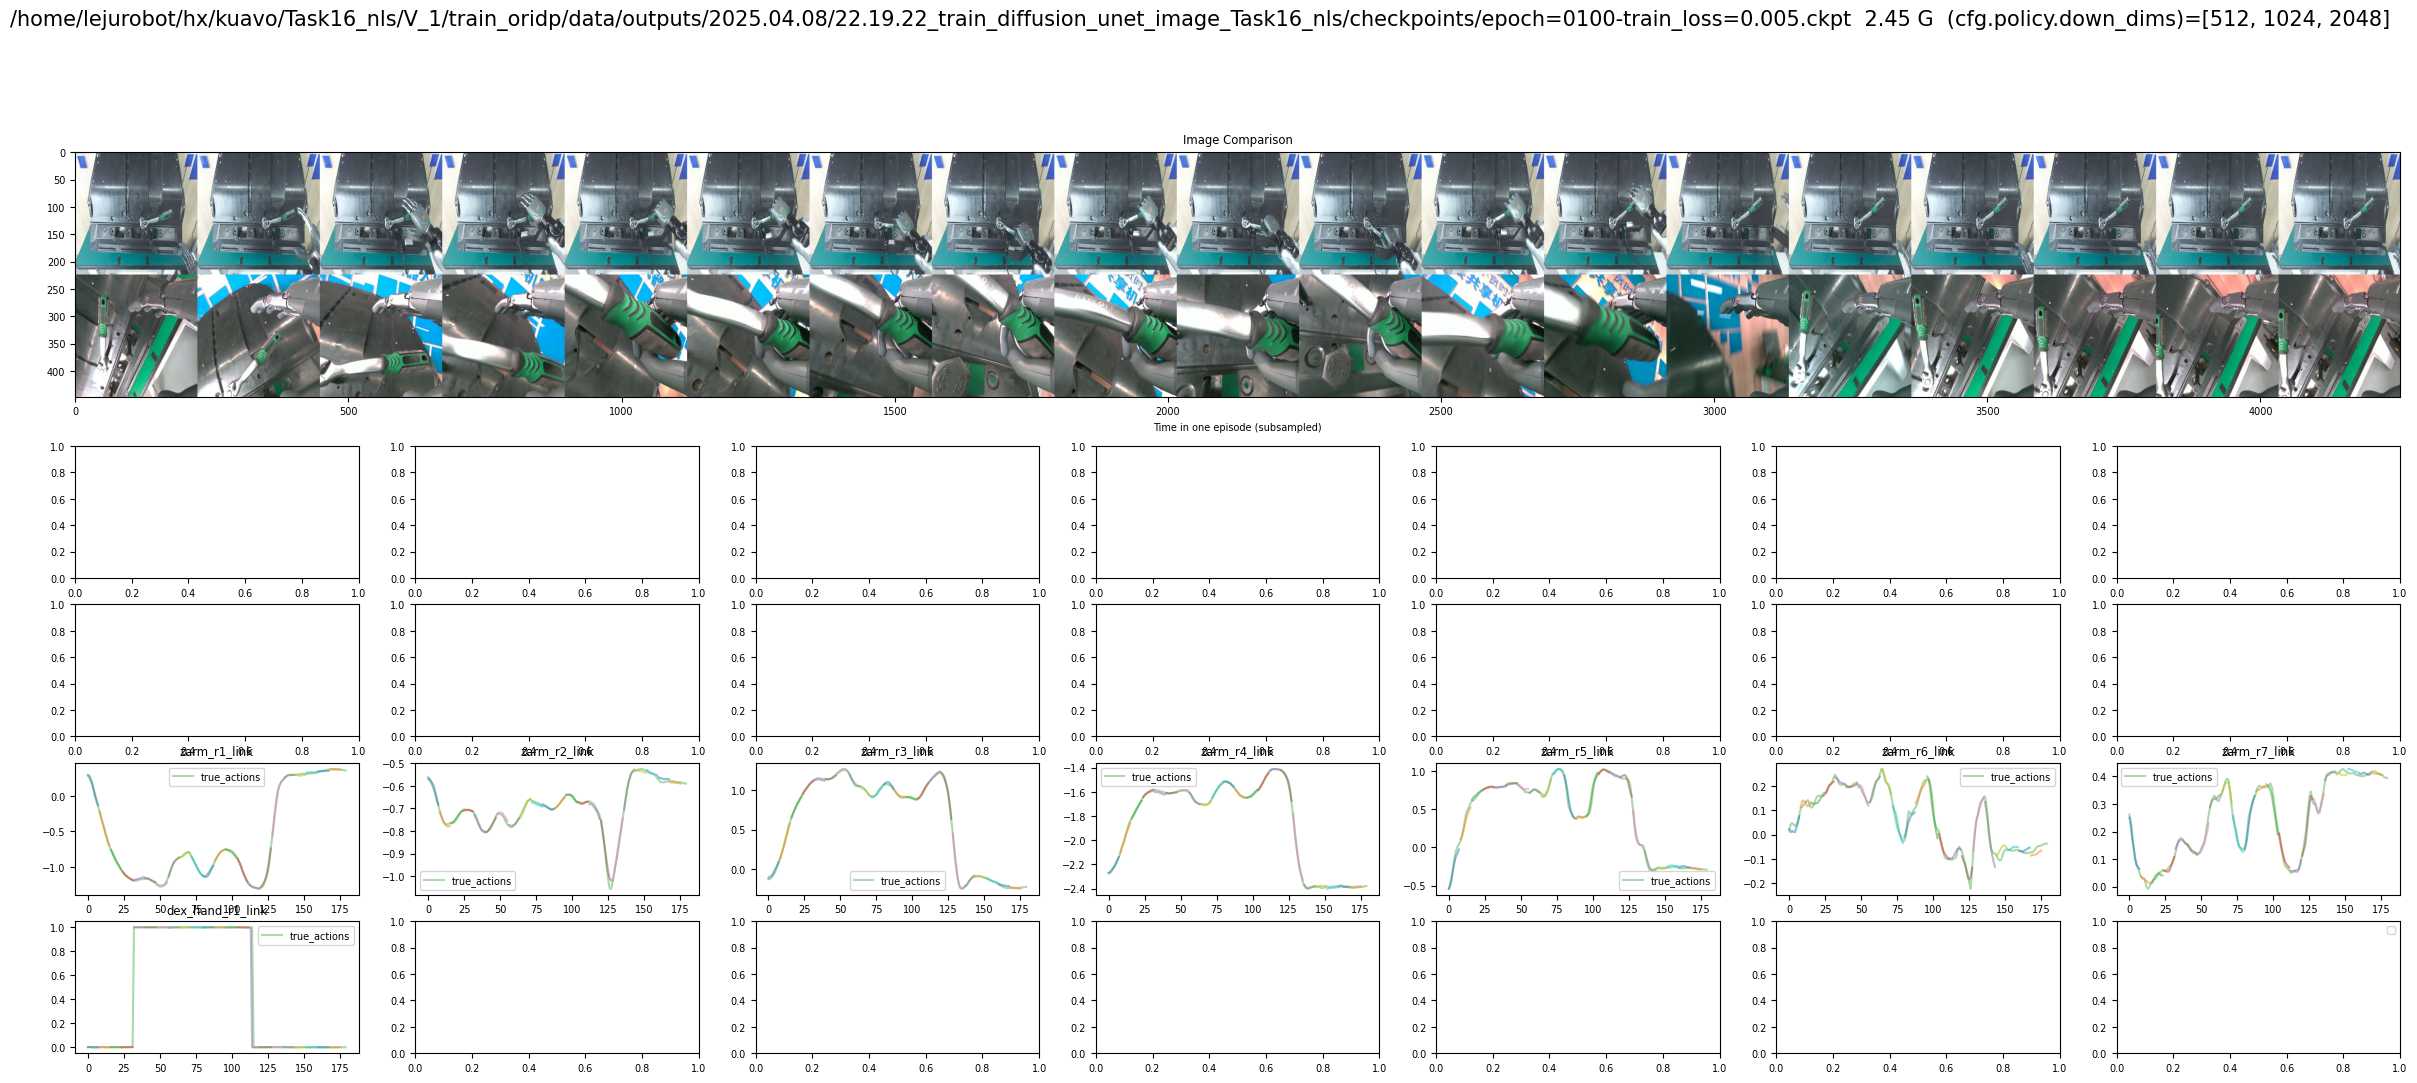

In [ ]:
# from plot import draw_predicted_result
task_name = ckpt_path + '  ' + f"{ckpt_size:.2f} G" + '  ' + f'{(cfg.policy.down_dims)=}'
slc = [(8, 8), (13, 21)]
for eps_idx in range(len(next(iter(all_img.values())))):
    draw_predicted_result(task_name, all_img, upBody_lowDim, eps_idx, slice_idx=slc)